In [1]:
# подключаем все необходимые библиотеки
import pandas as pd
import numpy as np
import networkx as nx

from geopy.distance import geodesic
from collections import deque

import plotly.graph_objects as go
import plotly.express as px

In [2]:
# режимы движения на отрезках маршрута
traffic_mode = pd.DataFrame(
    {
        'ice_class': ['No ice class', 'Ice1', 'Ice2', 'Ice3', 'Arc4', 'Arc5', 'Arc6', 'Arc7', 'Arc8', 'Arc9'],
        **{num: ['self', 'self', 'self', 'self', 'self', 'self', 'self', 'self', 'self', 'self'] for num in range(4)},
        **{num: ['wiring', 'wiring', 'wiring', 'wiring', 'self', 'self', 'self', 'self', 'self', 'self'] for num in range(4, 7)},
        **{num: ['forbidden', 'forbidden', 'forbidden', 'forbidden', 'wiring', 'wiring', 'wiring', 'self', 'self', 'self'] 
           for num in range(7, 10)},
    }
)

traffic_mode.head()

ice_class     0     1     2     3       4       5       6          7  \
0  No ice class  self  self  self  self  wiring  wiring  wiring  forbidden   
1          Ice1  self  self  self  self  wiring  wiring  wiring  forbidden   
2          Ice2  self  self  self  self  wiring  wiring  wiring  forbidden   
3          Ice3  self  self  self  self  wiring  wiring  wiring  forbidden   
4          Arc4  self  self  self  self    self    self    self     wiring   

           8          9  
0  forbidden  forbidden  
1  forbidden  forbidden  
2  forbidden  forbidden  
3  forbidden  forbidden  
4     wiring     wiring

In [3]:
# сплоченность льдов
cohesion = pd.read_csv('cohesion.csv', encoding='utf-8', sep=';')
cohesion = cohesion.rename(columns={
    'Номер ребра': 'edge_num',
})
cohesion.head()

edge_num  1  2  3  4  5  6  7  8  9  ...  21  22  23  24  25  26  27  28  \
0         1  0  0  0  0  0  0  0  0  0  ...   1   1   1   1   1   1   1   1   
1         2  0  1  1  1  1  2  2  2  2  ...   4   4   4   4   4   4   4   5   
2         3  1  1  1  1  2  2  2  2  2  ...   4   4   5   5   5   5   6   6   
3         4  0  0  0  0  0  0  0  0  0  ...   1   1   1   1   1   1   1   1   
4         5  0  0  0  0  0  0  0  0  0  ...   1   1   1   1   1   1   1   1   

   29  30  
0   1   2  
1   5   5  
2   6   6  
3   1   2  
4   2   2  

[5 rows x 31 columns]

In [4]:
# путь от самой заподной вершины
PATH_1 = [1, 2, 3, 7, 8, 9, 10]
PATH_2 = [4, 5, 6, 7, 8, 9, 10]

# до трех возможных портов
PORTS = [[12, 14], [12, 13], [11]]

TO = {
    'Саббета 1': [PATH_1 + PORTS[0], PATH_2 + PORTS[0]],
    'Саббета 2': [PATH_1 + PORTS[1], PATH_2 + PORTS[1]],
    'Саббета 3': [PATH_1 + PORTS[2], PATH_2 + PORTS[2]],
}

In [5]:
# загрузим датасет с данными о заявках на проход
requests = pd.read_csv('requests.csv', encoding='utf-8', sep=';')

# переименуем столбцы
requests.columns = [
    'name', 'imo', 'ice_class', 'speed', 'start_point', 'end_point', 'date_start', 'date_end'
]

# переведем столбцы с датой в нужный формат
requests['date_start'] = pd.to_datetime(requests['date_start'], format='%d.%m.%Y %H:%M')
requests['date_end'] = pd.to_datetime(requests['date_end'], format='%d.%m.%Y %H:%M')

# избавляемся ошибки в данных
requests.start_point = requests.start_point.str.strip()

for val in range(1, 3):
    requests.start_point = requests.start_point.str.replace(f'Сабетта {val}', f'Саббета {val}')
    requests.end_point = requests.end_point.str.replace(f'Сабетта {val}', f'Саббета {val}')

# переводим скорость из уздлов в км/ч
requests.speed *= 1.852   

requests.head()

name      imo ice_class  speed              start_point  \
0  Штурман Альбанов  9752084      Arc7  27.78  точка в Баренцевом море   
1  Штурман Альбанов  9752084      Arc7  27.78                Саббета 3   
2  Штурман Альбанов  9752084      Arc7  27.78  точка в Баренцевом море   
3  Штурман Альбанов  9752084      Arc7  27.78                Саббета 3   
4  Штурман Альбанов  9752084      Arc7  27.78  точка в Баренцевом море   

                 end_point          date_start            date_end  
0                Саббета 3 2021-01-01 23:30:00 2021-01-05 05:00:00  
1  точка в Баренцевом море 2021-01-06 11:00:00 2021-01-10 18:00:00  
2                Саббета 3 2021-01-12 18:00:00 2021-01-16 22:00:00  
3  точка в Баренцевом море 2021-01-17 06:00:00 2021-01-21 20:45:00  
4                Саббета 3 2021-01-21 09:00:00 2021-01-26 22:00:00

In [6]:
# функция для учета дней в декабре и феврале 
def clip_day(date) -> int:
    if date.month == 12:
        return 1
    if date.month == 2 or date.day == 31:
        return 30
    return date.day

# функция для определения необходимости проводки
def is_wiring_needed(ice_class, speed, start_point, end_point, date_start, date_end) -> bool: 
    if 'Саббета' in start_point:
        routes = [route[::-1] for route in TO[start_point]]
    else:
        routes = TO[end_point]
    
    start_day = clip_day(date_start)
    end_day = clip_day(date_end)
    
    for route in routes:
        max_difficulty = cohesion[cohesion.edge_num.isin(route)].loc[:, str(start_day):str(end_day)].values.max()
        mode = traffic_mode[traffic_mode.ice_class == ice_class][max_difficulty].values[0]
        decreased_speed = speed * (1 - max_difficulty * 0.07)
        
        if decreased_speed < 9 * 1.852:
            return True
        if mode != 'self':
            return True
    return False     

requests['wiring_needed'] = requests.apply(lambda x: is_wiring_needed(x['ice_class'], x['speed'], 
                                                                      x['start_point'], x['end_point'], 
                                                                      x['date_start'], x['date_end']), axis=1)

In [7]:
requests['start_point'].unique()

array(['точка в Баренцевом море', 'Саббета 3', 'Саббета 2', 'Саббета 1'],
      dtype=object)

In [8]:
print('Уникальных судов: ', requests.imo.nunique())

Уникальных судов:  17


In [9]:
print('Уникальные классы судов')
requests.pivot_table(index='ice_class', values='imo', aggfunc='nunique')

Уникальные классы судов


imo
ice_class        
Arc4            4
Arc5            3
Arc7            8
No ice class    2

In [10]:
# определим ширину и долготу для каждого порта и самой дальней точки в море
POINT_IN_SEA = (69.930300, 46.142578)
SABBETA_1 = (68.664551, 73.528748)
SABBETA_2 = (71.033035, 73.712769)
SABBETA_3 = (71.244356, 72.202148)

def set_point_coordinates(name):
    if name == 'точка в Баренцевом море':
        return POINT_IN_SEA
    if name == 'Саббета 3':
        return SABBETA_3
    if name == 'Саббета 2':
        return SABBETA_2
    if name == 'Саббета 1':
        return SABBETA_1

# добавим данные о широте и долготе в датафрейм
requests['start_point_coord'] = requests['start_point'].apply(set_point_coordinates)
requests['end_point_coord'] = requests['end_point'].apply(set_point_coordinates)

In [11]:
# загрузим данные о доступности ледокола на определенном пути
graph_availability = pd.read_csv('graph_availability.csv', encoding='utf-8', sep=';')
graph_availability = graph_availability.rename(columns={
    'Номер ребра': 'edge_num',
})
graph_availability

edge_num  50 лет Победы  Ямал  Таймыр  Вайгач
0          1              1     1       1       1
1          2              1     1       1       1
2          3              1     1       1       1
3          4              1     1       1       1
4          5              1     1       1       1
5          6              1     1       1       1
6          7              1     1       1       1
7          8              1     1       1       1
8          9              1     1       1       1
9         10              1     1       1       1
10        11              1     1       1       1
11        12              1     1       1       1
12        13              1     1       1       1
13        14              0     0       1       1

In [12]:
# загрузим координаты каждой вершины маршрутов
coordinates = pd.read_csv('json_coords.csv', encoding='utf-8', sep=',')
coordinates = coordinates.drop(['type', 'geometry_type'], axis=1)
coordinates = coordinates.rename(columns={
    'properties_id': 'edge_num',
    'geometry_coordinates_0_1': 'lat_0',
    'geometry_coordinates_0_0': 'lon_0',
    'geometry_coordinates_1_1': 'lat_1', 
    'geometry_coordinates_1_0': 'lon_1'})

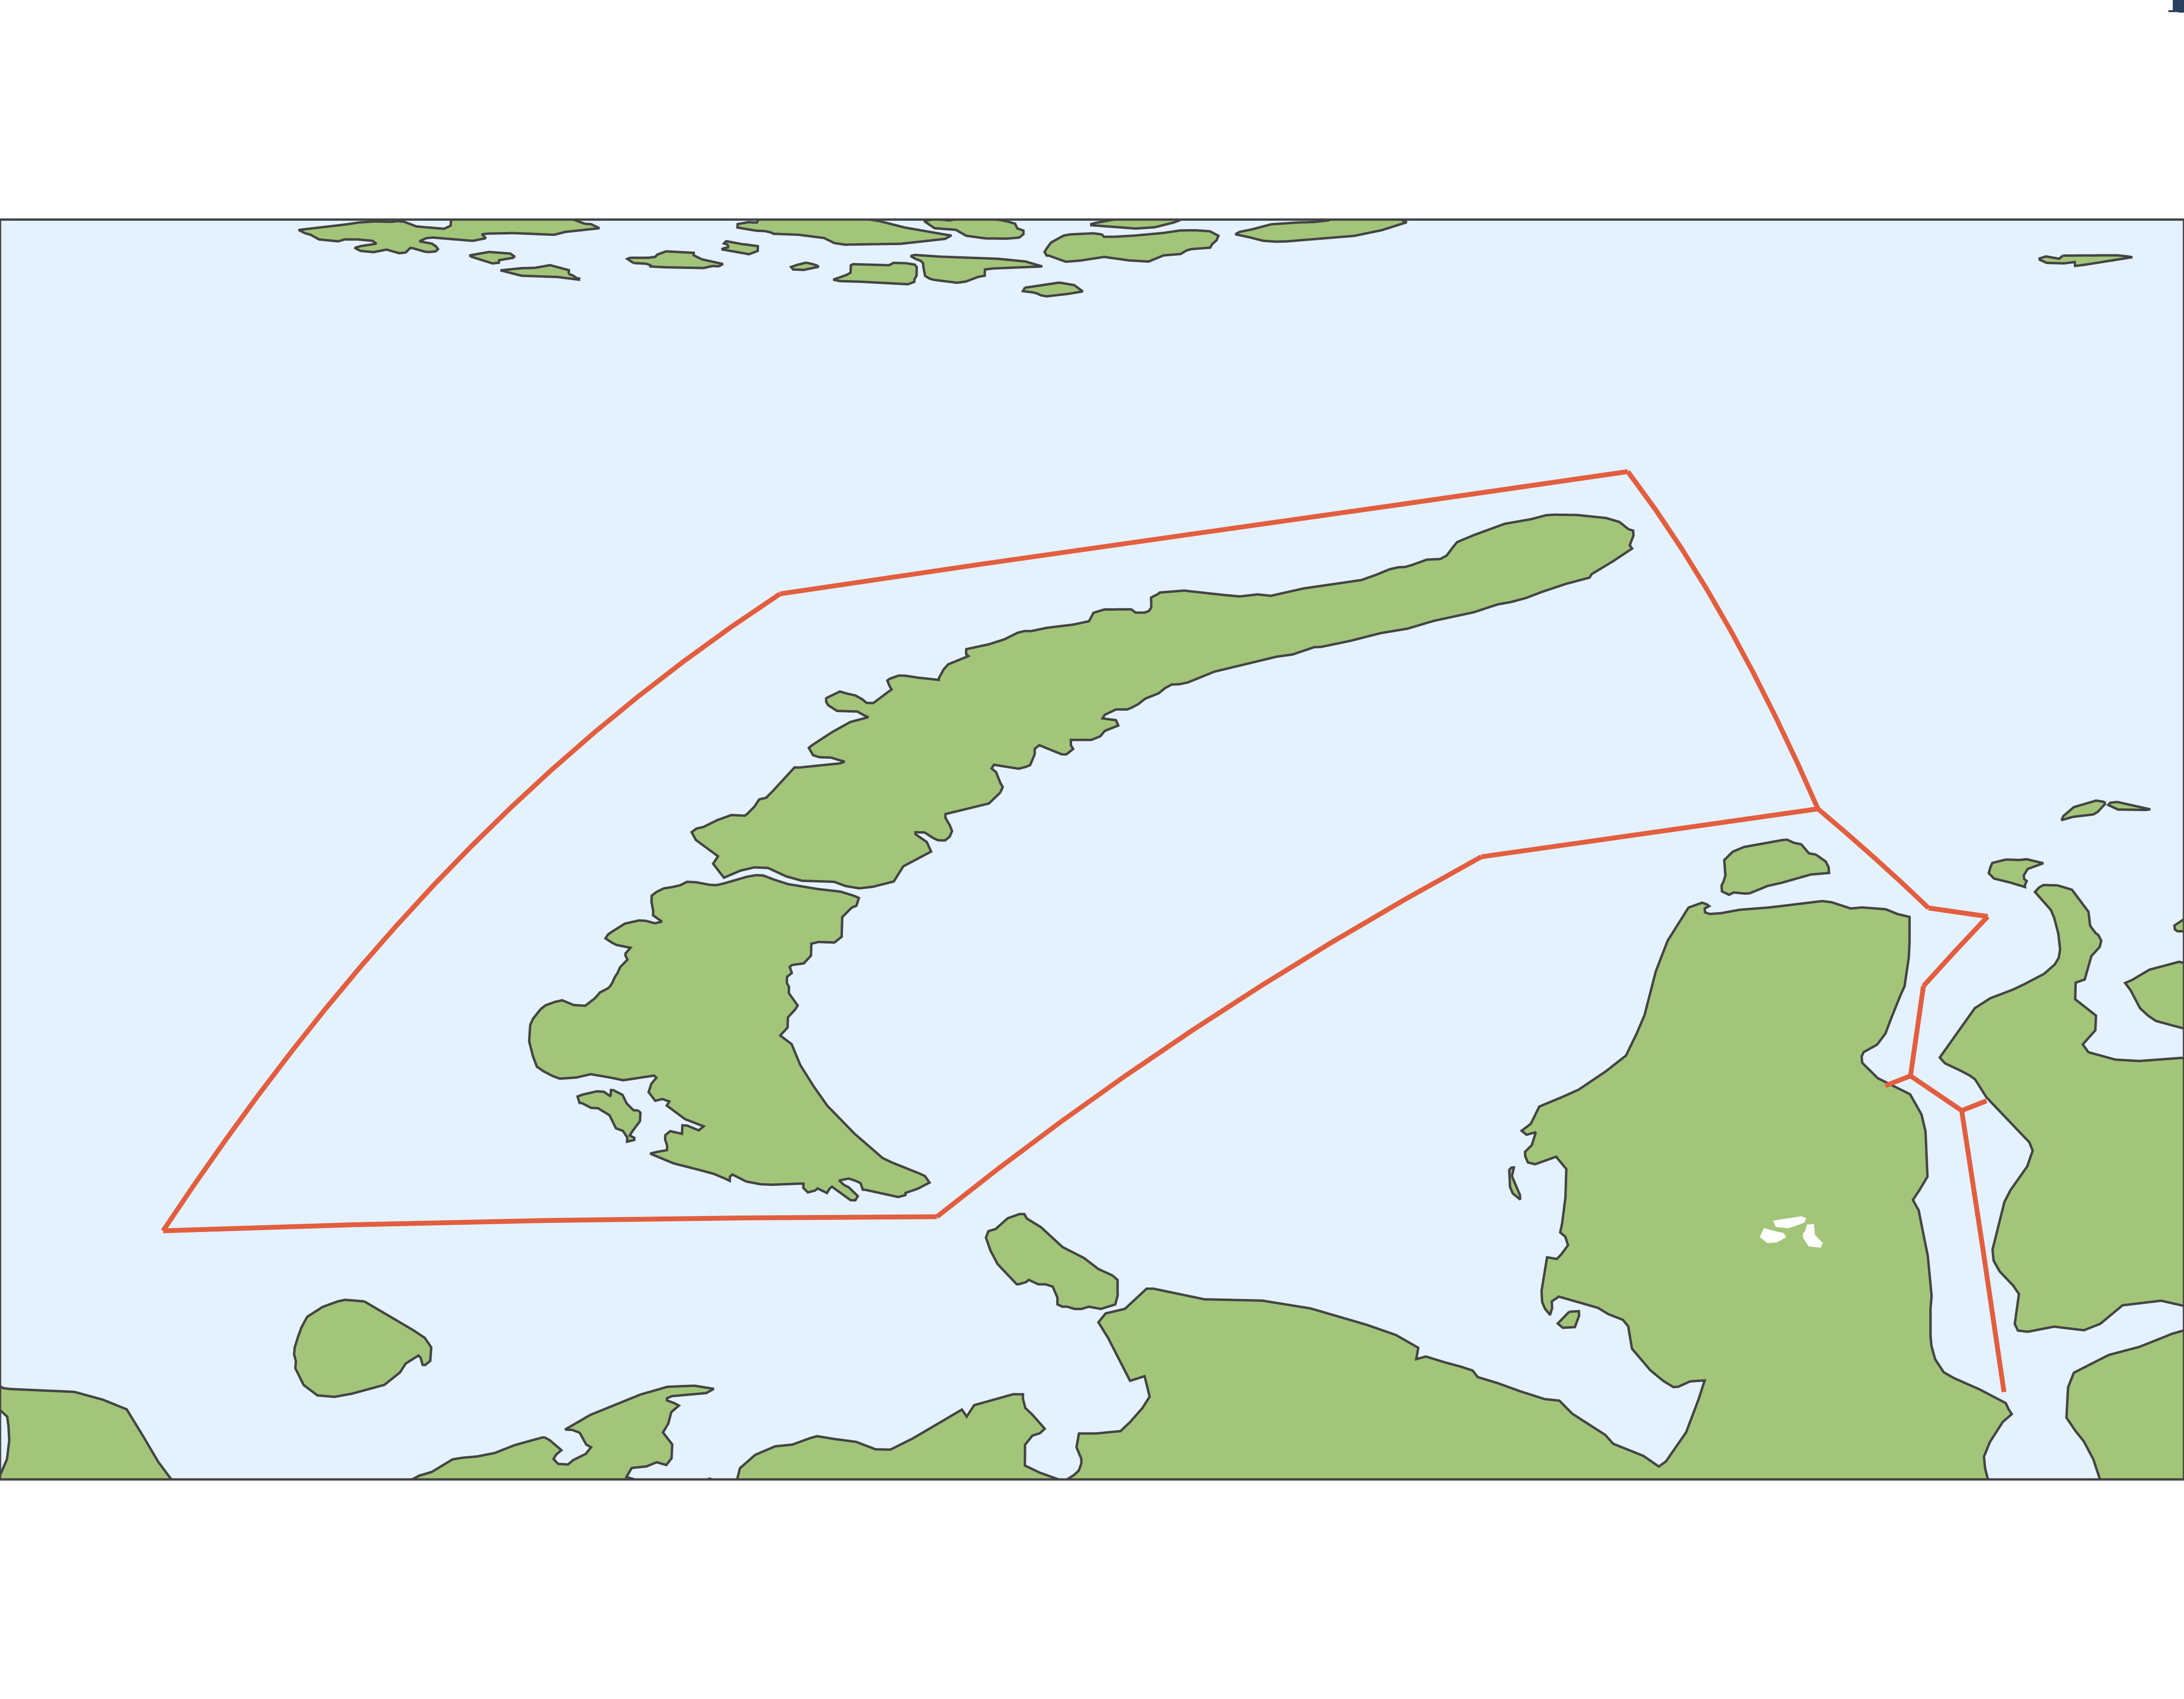

In [13]:
# отрисуем маршруты на карте
MARGIN = 2

fig = go.Figure()

i = 0
while i < coordinates.shape[0]:
    lon = [coordinates.loc[i, 'lon_0'], coordinates.loc[i, 'lon_1']]
    lat = [coordinates.loc[i, 'lat_0'], coordinates.loc[i, 'lat_1']]
    
    fig.add_trace(go.Scattergeo(
        lon=lon, lat=lat, mode='lines',
        hoverinfo='text', line=dict(color='#E25E3E'),
        text=str(coordinates.loc[i, 'edge_num']),
    ))
    
    fig.add_annotation(
        y=lon[0], x=lat[0], 
        text=str(coordinates.loc[i, 'edge_num']),
    )
    
    i += 1

    
fig.update_layout(
    width = 900,
    height = 700,
    showlegend = False,
    margin={"r":0,"t":0,"l":0,"b":0, "pad": 4, "autoexpand": True},
    geo = dict(
        resolution=50,
        showland=True, landcolor="#A2C579",
        showocean=True, oceancolor="#E4F1FF",
        projection = dict(
            type = 'albers',
        ),
        lataxis = dict(
            range = [coordinates.lat_0.min()-MARGIN, coordinates.lat_1.max()+MARGIN],
            showgrid = False,
        ),
        lonaxis = dict(
            range = [coordinates.lon_0.min()-MARGIN, coordinates.lon_1.max()+MARGIN],
            showgrid = False,
        ),
    ),
)
    
fig.show(renderer='png', scale=5)

К крайней точке в Баренцевом море примыкают ребра 1 (с Юга) и 4 (с Севера).

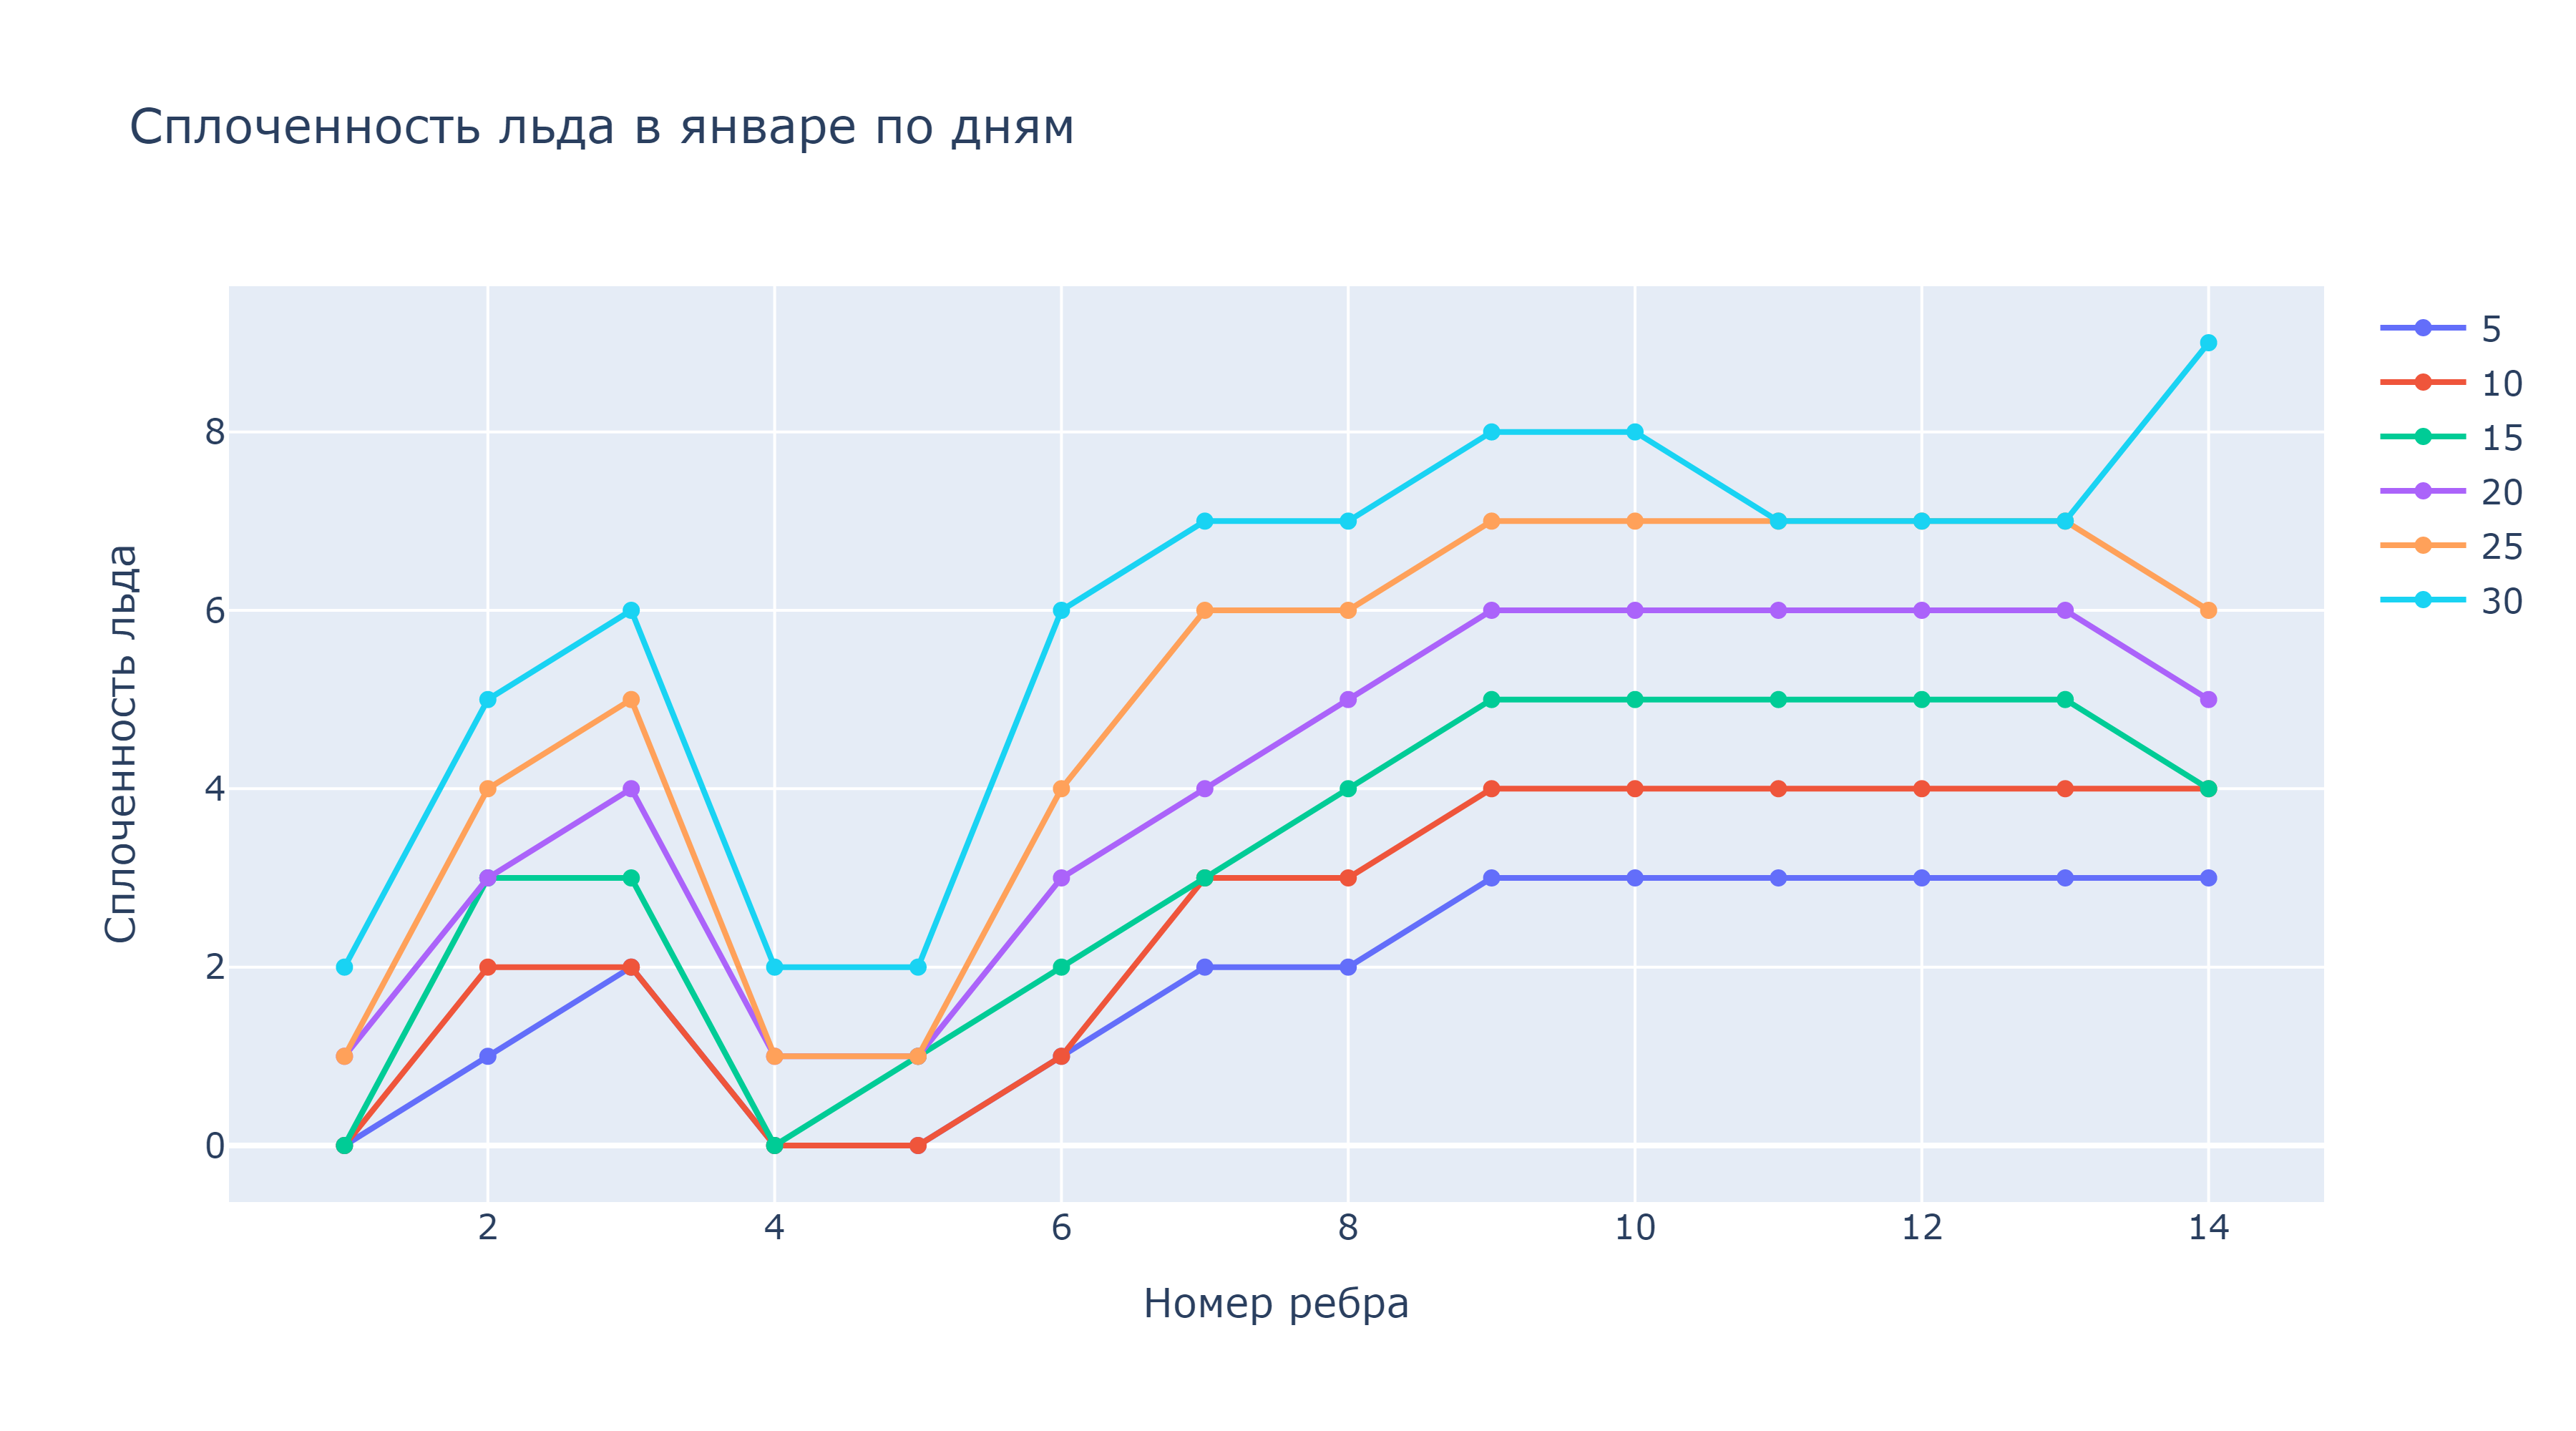

In [24]:
# нарисуем как меняется сплоченность льда в январе по дням
fig = go.Figure()

for i in range(5, 31, 5):
    fig.add_trace(go.Scatter(
        x=cohesion['edge_num'], y=cohesion[str(i)], name=str(i)
    ))
    
fig.update_layout(
    xaxis_title='Номер ребра',
    yaxis_title='Сплоченность льда',
    title='Сплоченность льда в январе по дням',
    width=900,
    height=500
)    
    
fig.show(renderer='png', scale=4)

Из графика видно, что обеспечевать ледовой проводкой суда на ребрах 1, 4 и 5 не нужно, поскольку сплоченность льда на них не будет превышать 2 весь январь.

In [15]:
# рассчитаем длину каждого ребра в километрах
def get_distance(lat_0, lon_0, lat_1, lon_1):
    return geodesic((lat_0, lon_0), (lat_1, lon_1)).km

coordinates['distance'] = coordinates.apply(lambda x: get_distance(x['lat_0'], x['lon_0'], x['lat_1'], x['lon_1']), axis=1)
coordinates.head()

edge_num      lon_0      lat_0      lon_1      lat_1    distance
0         1  46.142578  69.930300  57.744141  70.436799  442.053045
1         2  57.744141  70.436799  66.203613  73.534628  451.740435
2         3  66.203613  73.534628  71.542969  73.775780  169.870241
3         4  46.142578  69.930300  55.019531  76.205967  755.572096
4         5  55.019531  76.205967  68.906250  77.446940  378.488196

In [16]:
# выделим датасеты с заявками судов, которые не требуют проводки
requests_self = requests[requests.wiring_needed == False]

# и которые требуют проводку
requests_wiring = requests[requests.wiring_needed == True]

In [17]:
# функция для определения оптимальных маршрутов, времени, которое требуется затратить на преодоление ребра
# с учетом снижения скорости судна во льдах
def find_routes_with_wiring(name, ice_class, speed, start_point, end_point, date_start, date_end) -> dict:
    # определяем маршруты
    if 'Саббета' in start_point:
        routes = [route[::-1] for route in TO[start_point]]
    else:
        routes = TO[end_point]
    
    # задаем начальную и конечную дату, в соответствии с заявкой
    start_day = date_start.day
    end_day = date_end.day
    
    # определяем число минут в каждом дне (у начального и конечного дня, как правило, это не 24 часа)
    if date_start.date() == date_end.date():
        hours_per_day = [(date_end - date_start).total_seconds() / 60 / 24]
    else:
        start_day = start_day - 31 if start_day > end_day else start_day
        end_day = 31 + end_day if end_day < start_day else end_day
        
        full_days = end_day - start_day - 1
        hours_per_day = [24 - date_start.hour - date_start.minute / 60] + [24 for _ in range(full_days)] + \
                          [date_end.hour + date_end.minute / 60]
    
    # сюда будем сохранять данные
    route_time = []
    route_distance = []
    max_edge = []
    needed_wiring = []
    
    # запускаем цикл по всем маршрутам
    for route in routes:
        r = route.copy()
        flag = True
        
        needed_wiring.append([])
        
        while flag:
            total_time = {'edges': [], 'days': [], 'time_in_hours': []}
            
            edges = deque(r)
            hours = deque(hours_per_day)
            i = 0
            
            if not edges:
                max_edge.append('not allowed')
                break
            
            edge = edges.popleft()
            hour = hours.popleft()
            dist = coordinates.loc[coordinates.edge_num == edge, 'distance'].values[0]

            while True:

                day = clip_day(date_start + pd.DateOffset(days=i))
                
                # учитываем снижение скорости судна во льдах
                difficulty = cohesion[cohesion['edge_num'] == edge][str(day)].values[0]
                mode = traffic_mode[traffic_mode.ice_class == ice_class][difficulty].values[0] 
                decreased_speed = speed * (1 - difficulty * 0.07)
                
                if mode == 'forbidden':
                    # отмечаем случай, когда судну нельзя проходить ребро
                    flag = False
                    max_edge.append('not allowed')
                    break
                
                # в ледокольной проводке скорость всегда 9 узлов
                elif mode == 'wiring' or decreased_speed < 9 * 1.852:
                    decreased_speed = 9 * 1.852
                    if edge not in needed_wiring[-1]:
                        needed_wiring[-1].append(edge)
                
                # число часов, необходимых для преодоления ребра
                hours_needed = dist / decreased_speed
                
                # если число необходимых часов меньше часов, оставшихся в дне
                # то в этот же день переходим в следующее ребро
                if hours_needed <= hour:
                    total_time['edges'].append(edge)
                    total_time['days'].append(day)
                    total_time['time_in_hours'].append(hours_needed)
                    
                    # оставшиеся часы в дне
                    hour -= hours_needed

                    if not edges:
                        flag = False
                        break

                    edge = edges.popleft()
                    
                    dist = coordinates.loc[coordinates.edge_num == edge, 'distance'].values[0]
                else:
                    total_time['edges'].append(edge)
                    total_time['days'].append(day)
                    total_time['time_in_hours'].append(hour)

                    if not hours:
                        # если не успели доплыть до конечного ребра маршрута
                        # удаляем одно ребро в Баренцевом море
                        r.remove(min(r))  
                        break

                    i += 1  # следующий день
                    
                    # сколько осталось проплыть от ребра
                    dist -= hour * decreased_speed
                    hour = hours.popleft()
        
        if r and 'not allowed' not in max_edge:
            max_edge.append(r)
            route_distance.append(coordinates.loc[coordinates.edge_num.isin(r), 'distance'].values.sum())
            
        route_time.append(total_time)
        
    
    return {
        'ship_name': name,
        'routes': max_edge,
        'opt_time_of_routes': route_time,
        'distance_of_routes': route_distance,
        'total_time_of_routes': [sum(route_time[i]['time_in_hours']) for i in range(len(route_time))],
        'needed_wiring': needed_wiring,
        'request_dates': [date_start, date_end]
    }

res = requests.apply(lambda x: find_routes_with_wiring(x['name'], x['ice_class'], x['speed'], 
                                                       x['start_point'], x['end_point'], 
                                                       x['date_start'], x['date_end']), axis=1)

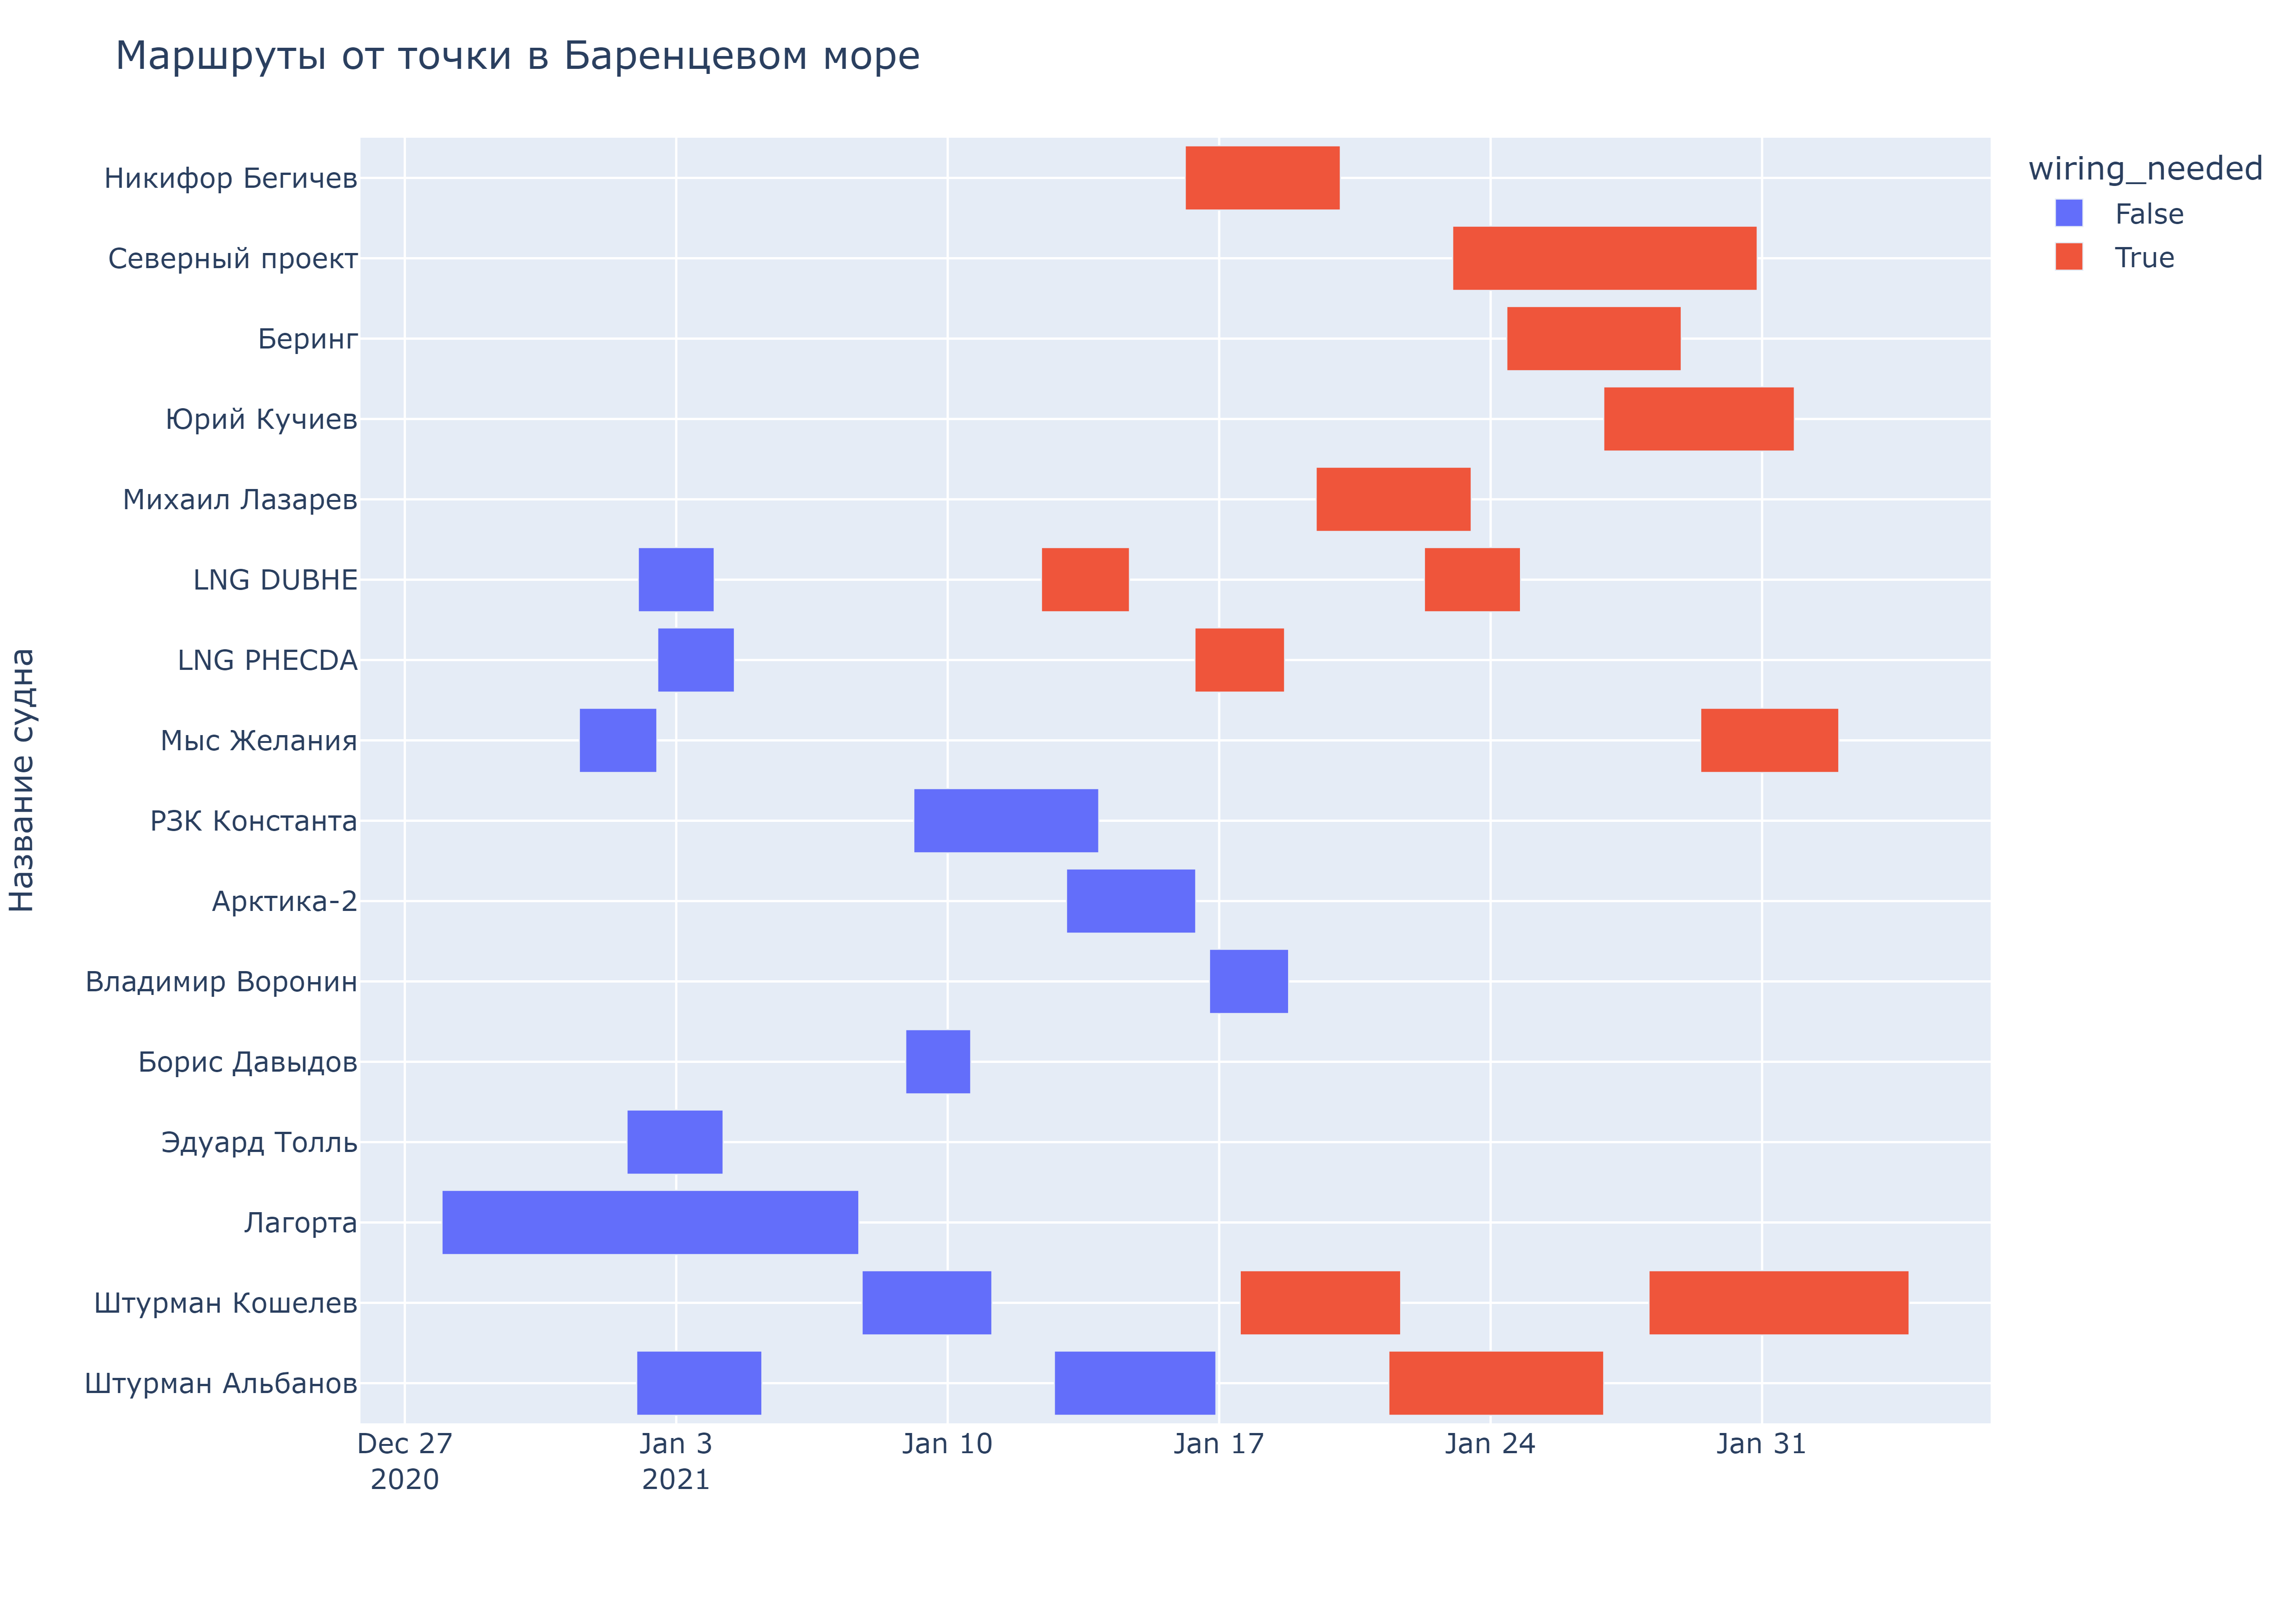

In [18]:
# построим два Гант чарта

# первый - для всех маршрутов из Баренцева моря 
fig = px.timeline(requests[requests.start_point == 'точка в Баренцевом море'], 
                  x_start='date_start', x_end='date_end', y='name', color='wiring_needed')
fig.update_layout(height=700, width=1000, yaxis=dict(showgrid=True, title='Название судна'), title='Маршруты от точки в Баренцевом море')
fig.show(renderer='png', scale=5)

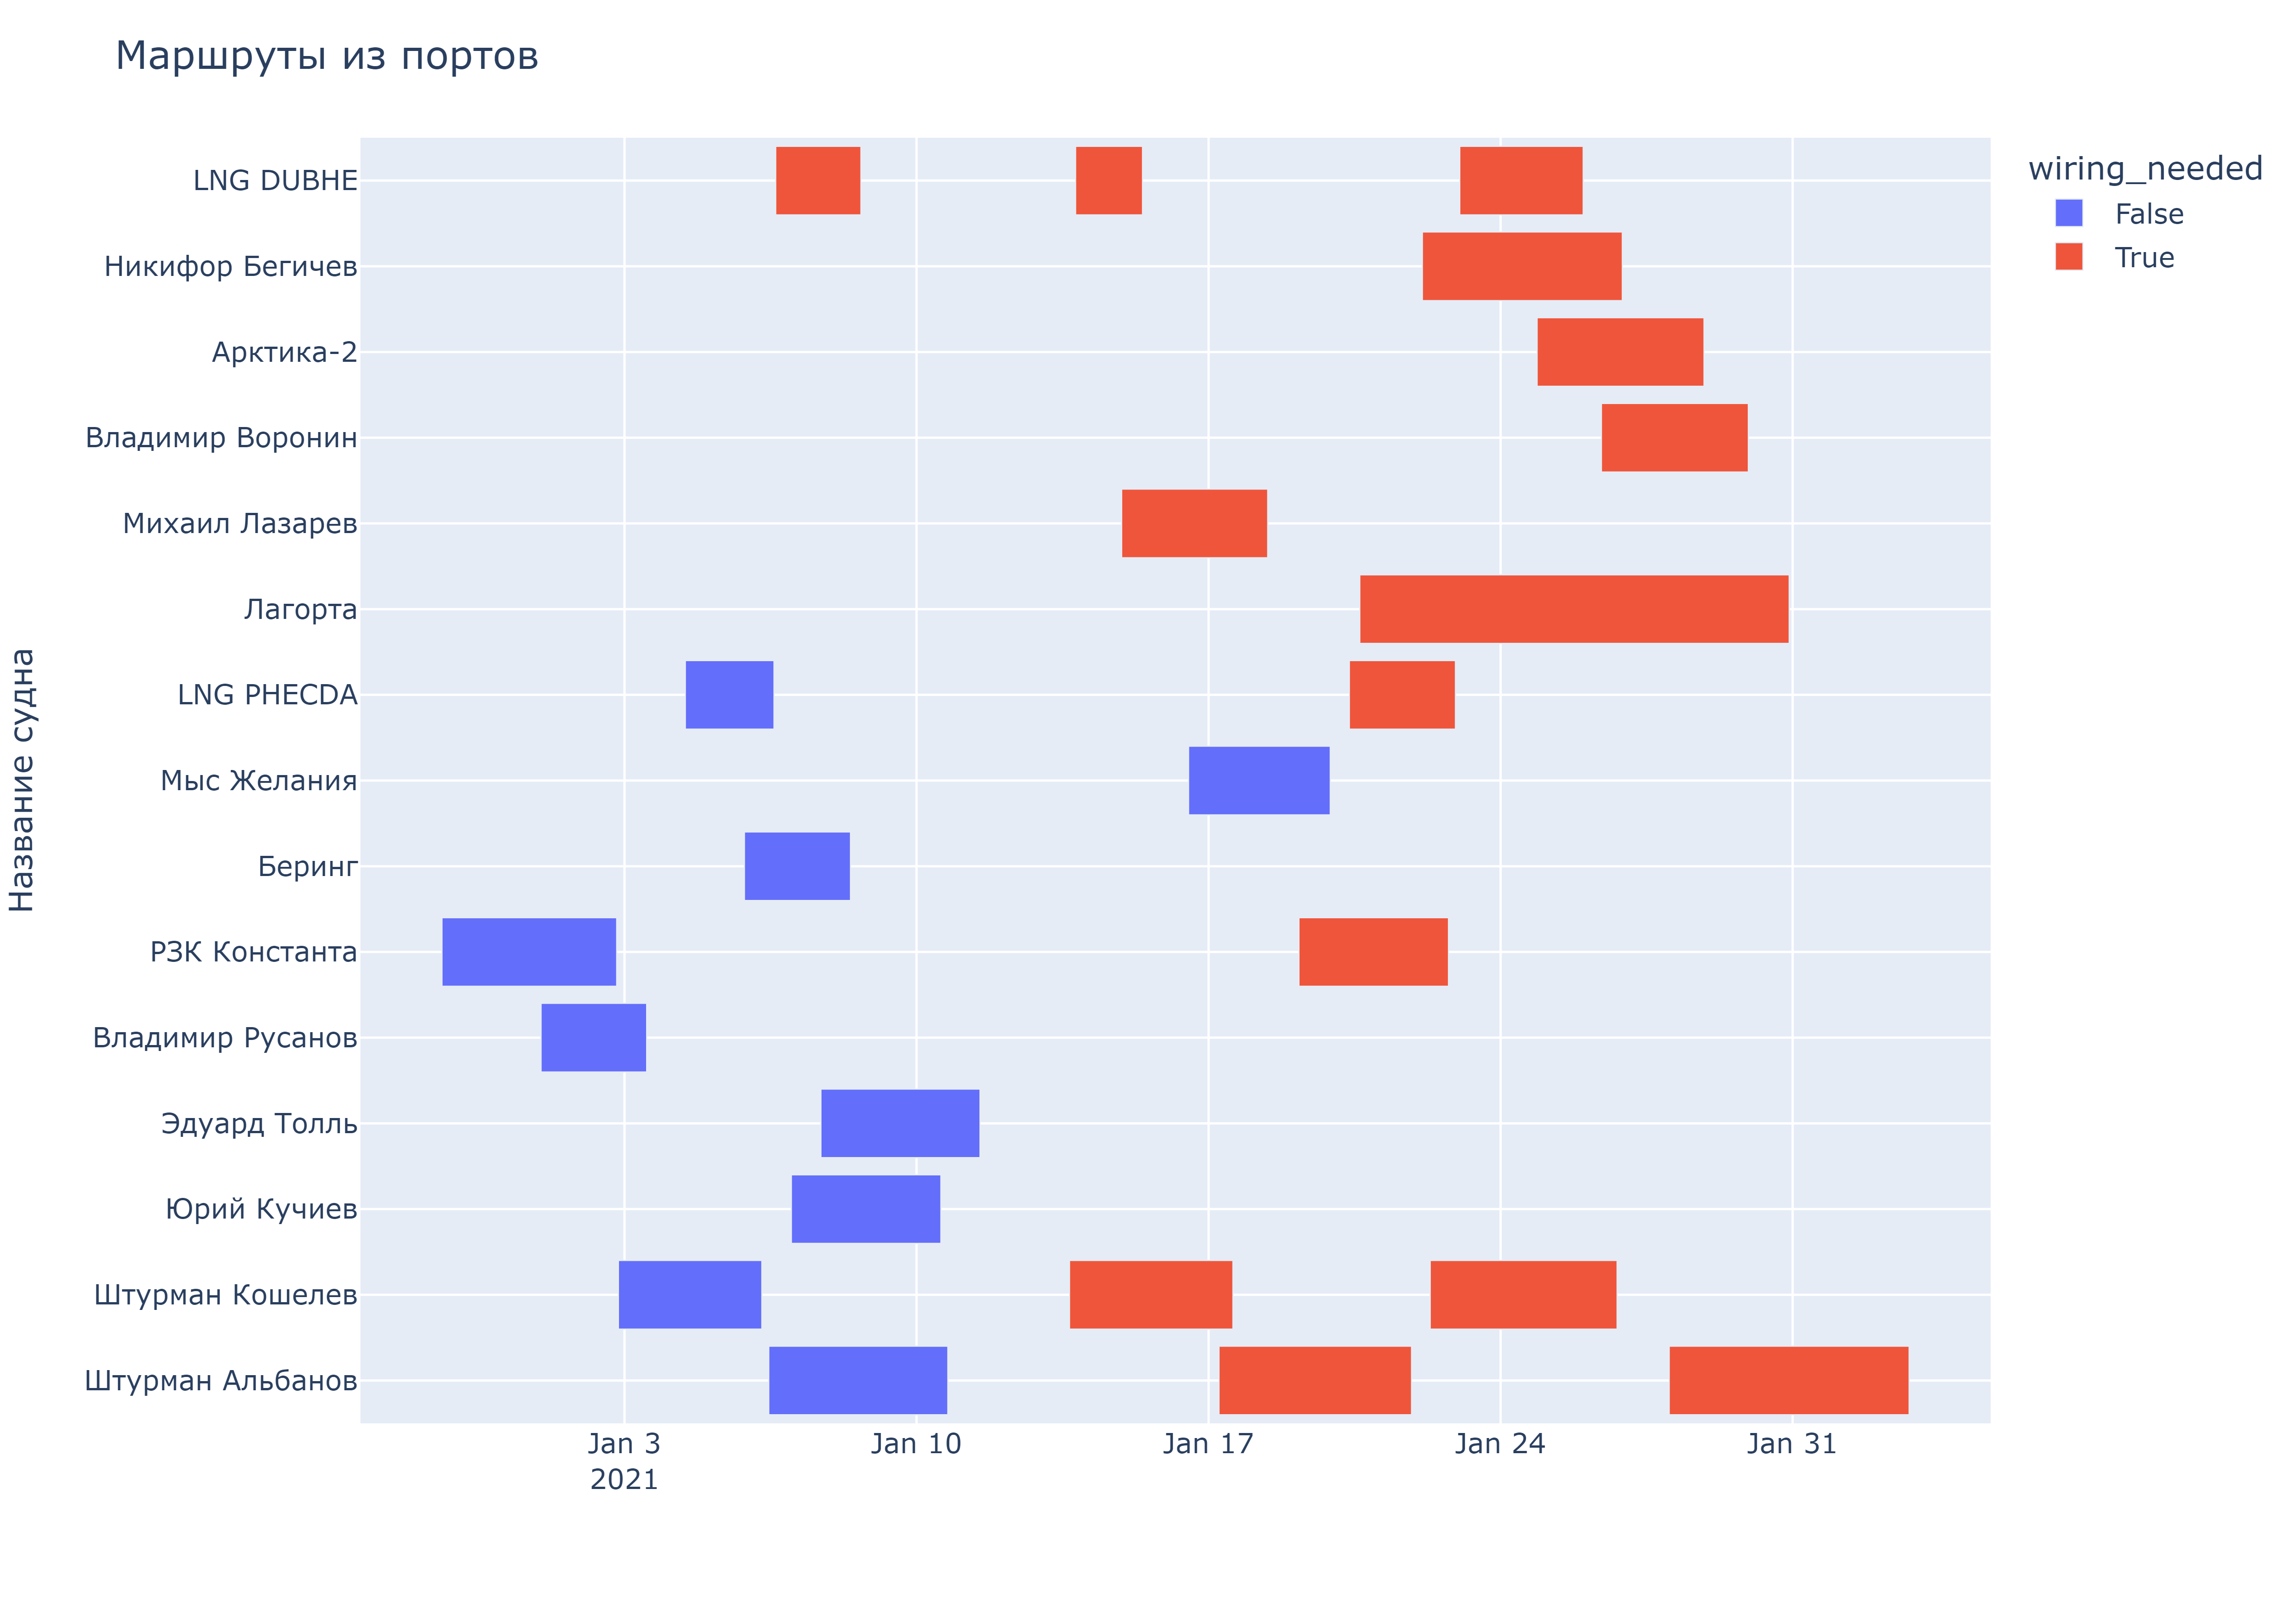

In [19]:
# второй - для всех маршрутов из портов
fig = px.timeline(requests[requests.start_point != 'точка в Баренцевом море'], 
                  x_start='date_start', x_end='date_end', y='name', color='wiring_needed')
fig.update_layout(height=700, width=1000, yaxis=dict(showgrid=True, title='Название судна'), title='Маршруты из портов')
fig.show(renderer='png', scale=5)

Видим, что ледокольная проводка понадобится в основном после середины января.

In [20]:
# формируем данные по проводке: для какого судна, когда, откуда и куда
ports = {
    14: 'Саббета 1 (14)',
    13: 'Саббета 2 (13)',
    11: 'Саббета 3 (11)',
}

day_edge_with_wiring = {}
gant_wiring = pd.DataFrame(columns=['ship_name', 'date_start', 'date_end', 'edge_start', 'edge_end', 'destination'])

for j, r in enumerate(res):
    if 'not allowed' in r['routes']:
        continue
        
    optim_route = r['total_time_of_routes'].index(min(r['total_time_of_routes']))
    if r['ship_name'] not in day_edge_with_wiring:
        day_edge_with_wiring[r['ship_name']] = []
    
    indexes = [i for i, e in enumerate(r['opt_time_of_routes'][optim_route]['edges']) if e in r['needed_wiring'][optim_route]]
        
    edges = [e for i, e in enumerate(r['opt_time_of_routes'][optim_route]['edges']) if i in indexes]
    days = [e for i, e in enumerate(r['opt_time_of_routes'][optim_route]['days']) if i in indexes]
    hours = [e for i, e in enumerate(r['opt_time_of_routes'][optim_route]['time_in_hours']) if i in indexes]
        
    day_edge_with_wiring[r['ship_name']].append({
        'edges_with_wiring': edges,
        'days_with_wiring': days,
        'hours_with_wiring': hours
    })

    if days:
        destination = ports[edges[-1]] if edges[-1] in ports else 'точка в Баренцевом море'
        
        if r['request_dates'][0].day == days[0]:
            start = r['request_dates'][0]
        else:
            start = pd.to_datetime(f'2021-01-{days[0] + 1}') - pd.DateOffset(hours=hours[0])
            
        end = pd.to_datetime(start + pd.DateOffset(hours=sum(hours)))
        gant_wiring.loc[gant_wiring.shape[0]] = [r['ship_name'], start, end, edges[0], edges[-1], destination]

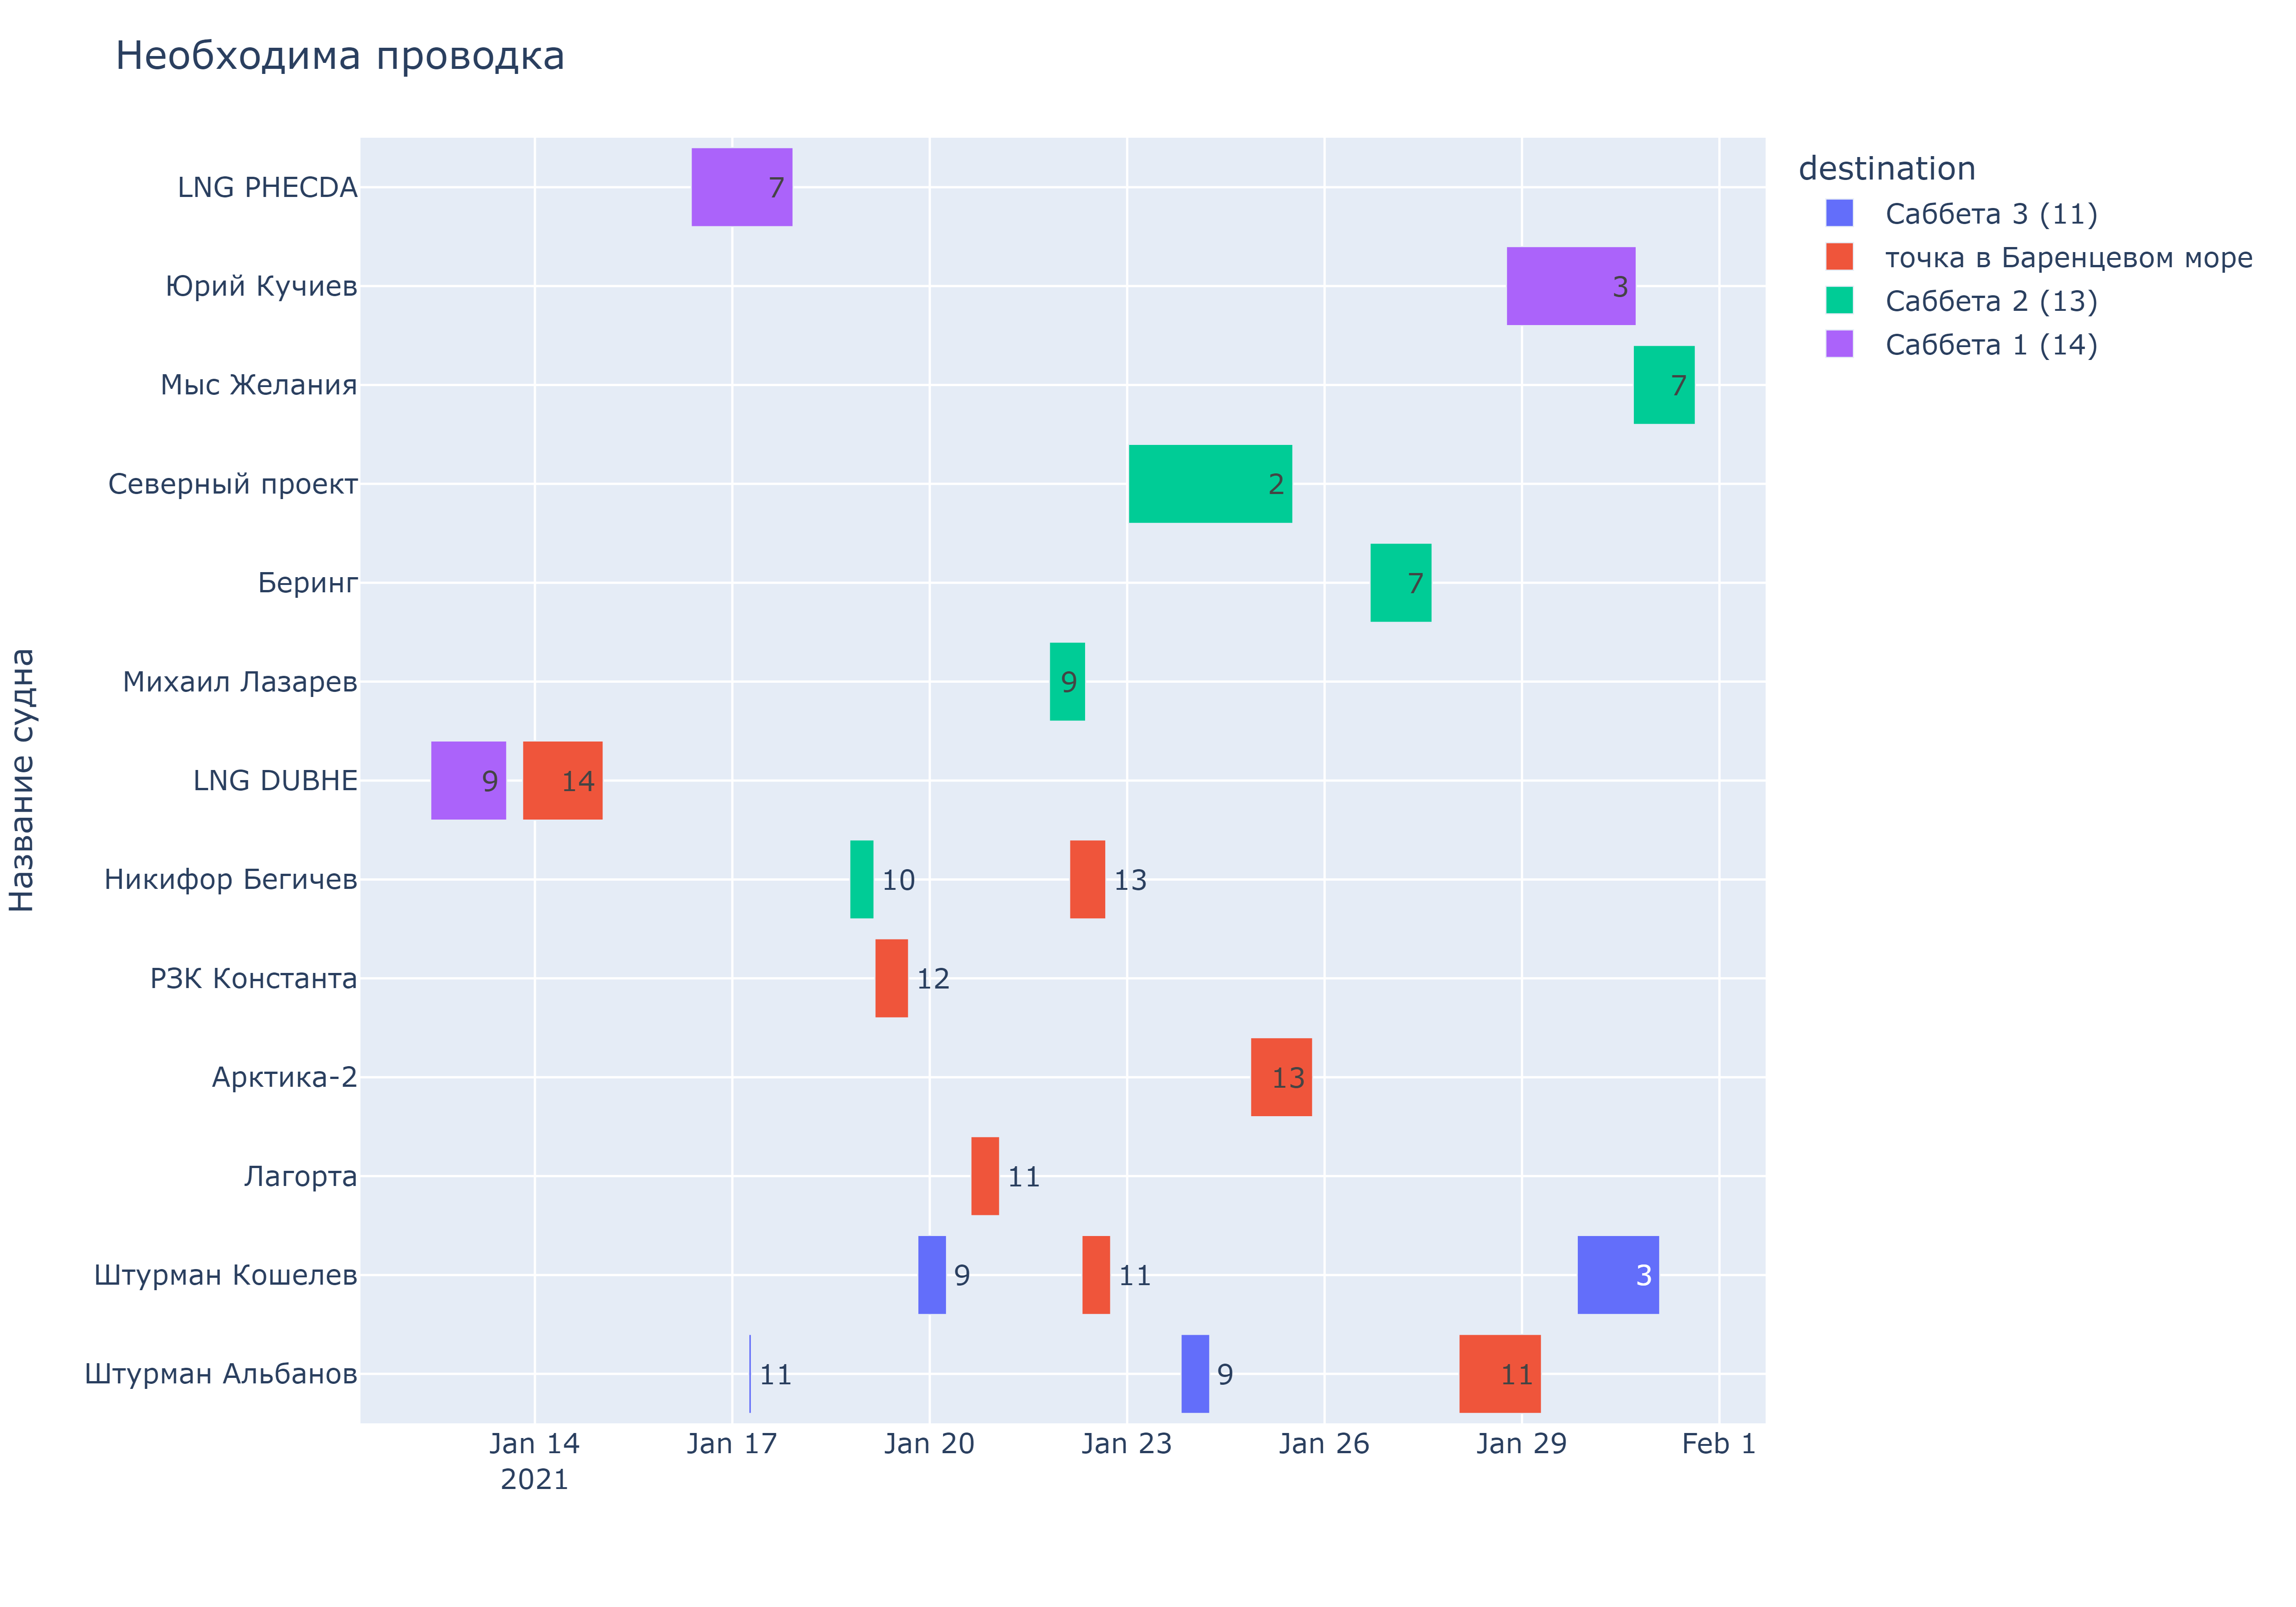

In [21]:
# построим Гант чарт для заявок, которым на части маршрута потребуется ледокольная проводка
# числа на графика - то, откуда плывет судно
fig = px.timeline(gant_wiring, x_start='date_start', x_end='date_end', y='ship_name', color='destination', text='edge_start')
fig.update_layout(height=700, width=1000, yaxis=dict(showgrid=True, title='Название судна'), title='Необходима проводка')
fig.show(renderer='png', scale=5)

In [22]:
gant_wiring.sort_values(by='date_start')

ship_name                 date_start                   date_end  \
17         LNG DUBHE 2021-01-12 10:00:00.000000 2021-01-13 13:43:41.304646   
18         LNG DUBHE 2021-01-13 19:30:00.000000 2021-01-15 00:54:45.634227   
16        LNG PHECDA 2021-01-16 09:00:00.000000 2021-01-17 22:09:12.697554   
0   Штурман Альбанов 2021-01-17 06:00:00.000000 2021-01-17 06:57:02.651630   
14   Никифор Бегичев 2021-01-18 18:49:29.632292 2021-01-19 03:41:00.979332   
10     РЗК Константа 2021-01-19 04:00:00.000000 2021-01-19 16:16:31.391337   
3    Штурман Кошелев 2021-01-19 19:38:25.797880 2021-01-20 06:07:33.019338   
6            Лагорта 2021-01-20 15:00:00.000000 2021-01-21 01:29:07.221458   
7     Михаил Лазарев 2021-01-21 19:38:25.797880 2021-01-22 08:51:31.347040   
15   Никифор Бегичев 2021-01-22 03:00:00.000000 2021-01-22 16:13:05.549160   
4    Штурман Кошелев 2021-01-22 07:30:00.000000 2021-01-22 17:59:07.221458   
12   Северный проект 2021-01-23 00:30:00.000000 2021-01-25 12:26:14.107501   
1   Штурман Альбанов 2021-01-23 19:38:25.797880 2021-01-24 06:07:33.019338   
9          Арктика-2 2021-01-24 21:00:00.000000 2021-01-25 19:38:36.942068   
11            Беринг 2021-01-26 16:34:16.764572 2021-01-27 15:12:53.706640   
2   Штурман Альбанов 2021-01-28 01:00:00.000000 2021-01-29 07:06:07.651230   
8        Юрий Кучиев 2021-01-28 18:18:40.442809 2021-01-30 17:39:22.177228   
5    Штурман Кошелев 2021-01-29 20:07:40.190914 2021-01-31 02:13:47.842144   
13       Мыс Желания 2021-01-30 16:34:16.764572 2021-01-31 15:12:53.706640   

    edge_start  edge_end              destination  
17           9        14           Саббета 1 (14)  
18          14         8  точка в Баренцевом море  
16           7        14           Саббета 1 (14)  
0           11        11           Саббета 3 (11)  
14          10        13           Саббета 2 (13)  
10          12         9  точка в Баренцевом море  
3            9        11           Саббета 3 (11)  
6           11         9  точка в Баренцевом море  
7            9        13           Саббета 2 (13)  
15          13         9  точка в Баренцевом море  
4           11         9  точка в Баренцевом море  
12           2        13           Саббета 2 (13)  
1            9        11           Саббета 3 (11)  
9           13         7  точка в Баренцевом море  
11           7        13           Саббета 2 (13)  
2           11         3  точка в Баренцевом море  
8            3        14           Саббета 1 (14)  
5            3        11           Саббета 3 (11)  
13           7        13           Саббета 2 (13)

In [23]:
# информация по ледоклам
icebreakers = pd.read_csv('icebreakers.csv', encoding='utf-8', sep=';')
icebreakers.columns = ['name', 'imo']

icebreakers['start_point'] = [9, 11, 12, 13]
icebreakers['in_journey'] = [False, False, False, False]
icebreakers

name      imo  start_point  in_journey
0  50 лет Победы  9152959            9       False
1           Ямал  9077549           11       False
2         Таймыр  8417481           12       False
3         Вайгач  8417493           13       False

In [25]:
#инициализация матрицы смежности
col_matrix = pd.read_csv('col_matrix.csv', encoding='utf-8', sep=';', index_col='Unnamed: 0')

In [54]:
#список рёбер в пути до точки:
def get_ribs_for_path(start_edge, end_edge, col_matrix):
    graph = nx.from_numpy_array(col_matrix.to_numpy(), create_using=nx.DiGraph())
    path = nx.dijkstra_path(graph, start_edge-1, end_edge-1)
    return list(map(lambda x: x + 1, path))

#генерация time series на всём протяжении пути
def generate_time_range(start, end, freq):
    time_series = []
    start_time = rounder(start)
    end_time = rounder(end)
    current_time = start_time
    td = pd.Timedelta(hours=freq)
    while current_time <= end_time:
        time_series.append(current_time)
        current_time+=pd.Timedelta(hours=1)
    return time_series

#округление по времени (в точную работу функции не вникал)
def rounder(t):
    if t.minute >= 30:
        return t.replace(second=0, microsecond=0, minute=0, hour=t.hour+1)
    else:
        return t.replace(second=0, microsecond=0, minute=0)
    
def is_ice_needed(ice_coh, ice_class):
    return True#temp
def get_ice_coh(rib_number, day):
    return 5#temp
def get_ribs_lengths(ribs):
    lengths = []
    for rib in ribs:
        lengths.append(get_rib_length(rib))
    return lengths
def get_rib_length(rib_number):
    return 100#temp
def get_ice_hardness(rib, day):
    return 5#temp


def get_ribs_for_ship(ship, speed, ice_class, freq):
    ribs = get_ribs_for_path(ship.edge_start, ship.edge_end, col_matrix)
    #округление времени до ближайшего часа (вроде бы)
    #инициализация рёбер
    time_range = generate_time_range(ship.date_start, ship.date_end, freq)
    #инициализация длин рёбер
    ribs_lengths = get_ribs_lengths(ribs)

    #инициализируем первое ребро: порядковый номер в пути и длину
    
    current_rib_index = 0
    current_rib_number = ribs[current_rib_index]
    current_rib_remaining_length = ribs_lengths[current_rib_index]
    
    time_ribs = pd.DataFrame(data=None, index=time_range, columns=['rib', 'need_ice'])

    for timestamp in time_range:
        ice_coh = get_ice_coh(current_rib_number, timestamp.day)
        is_ice = is_ice_needed(ice_coh, ice_class)
        current_rib_remaining_length-= speed * 1 * 0.7 * ice_coh
        #добавить в датафрейм строчку {id: время, номер ребра, проходимо оно или нет для этого корабля}
        new_row = {'rib':current_rib_index, 'need_ice':is_ice}
        #time_ribs.append(pd.DataFrame(data=new_row, index=[timestamp], columns=['rib', 'need_ice']))
        time_ribs.loc[timestamp, 'rib'] = current_rib_number
        time_ribs.loc[timestamp, 'need_ice'] = is_ice
        #условие, если мы прошли ребро, переходим на рассчёт следующего
        if current_rib_remaining_length <=0:

            if current_rib_index == len(ribs) - 1:
                break
            else:
                current_rib_index+=1
                current_rib_number = ribs[current_rib_index]
                current_rib_remaining_length = ribs_lengths[current_rib_index]
    return time_ribs.dropna()

def get_tables_array(gant_wiring):
    tables = []
    for i in range(1, len(gant_wiring.index)):
        tables.append(get_ribs_for_ship(gant_wiring.iloc[i], 25, 5, 1))
    return tables

def get_final_table(tables):
    time_range = generate_time_range(gant_wiring.date_start.min(), gant_wiring.date_end.max(), 1)
    columns=[1,2,3,4,5,6,7,8,9,10,11,12,13,14]
    time_series_dataframe = pd.DataFrame(data=0, index=time_range, columns=columns)
    for table in tables:
        for i in table.index:
            rib = table.loc[i].rib
            sum = 0
            if table.loc[i].need_ice == True:
                sum_ = 1
            time_series_dataframe.loc[i, rib]+=sum_
    return time_series_dataframe

In [56]:
# получим таблицу, где каждый час с 12.01 по 31.01 отображается, на каких ребрах нужна проводка для скольких судов
wiring_by_hour = get_final_table(get_tables_array(gant_wiring))
wiring_by_hour

1   2   3   4   5   6   7   8   9   10  11  12  13  14
2021-01-12 10:00:00   0   0   0   0   0   0   0   0   1   0   0   0   0   0
2021-01-12 11:00:00   0   0   0   0   0   0   0   0   1   0   0   0   0   0
2021-01-12 12:00:00   0   0   0   0   0   0   0   0   0   1   0   0   0   0
2021-01-12 13:00:00   0   0   0   0   0   0   0   0   0   1   0   0   0   0
2021-01-12 14:00:00   0   0   0   0   0   0   0   0   0   0   0   1   0   0
...                  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..
2021-01-31 11:00:00   0   0   0   0   0   0   0   0   0   0   0   0   0   0
2021-01-31 12:00:00   0   0   0   0   0   0   0   0   0   0   0   0   0   0
2021-01-31 13:00:00   0   0   0   0   0   0   0   0   0   0   0   0   0   0
2021-01-31 14:00:00   0   0   0   0   0   0   0   0   0   0   0   0   0   0
2021-01-31 15:00:00   0   0   0   0   0   0   0   0   0   0   0   0   0   0

[462 rows x 14 columns]